In [1]:
!pip install graphlearning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for graphlearning: filename=graphlearning-1.2.1-cp38-cp38-linux_x86_64.whl size=143762 sha256=3eafe78e57a3f6a86285aff04964fad25653978cd955348f0767284f6977d34c
  Stored in directory: /root/.cache/pip/wheels/5e/84/62/681cf2c2a59f1f5e58d52fb110e2eb4c93c9c808d932829543
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=712fc900391fa13cdd31cc93c33595c0f060f83aa5edf8a9d1087f90b1053b10
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built graphlearning sklearn


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy.optimize import minimize, LinearConstraint
import sklearn.datasets as datasets
import scipy
import time
import pickle

## Cheat sheet
$$I[u] = \frac{1}{2p} \sum_{i,j=1}^n w_{i j} | \nabla u(x_i,x_j) |^p - \sum_{j=1}^m(y_j - \bar{y}) \cdot u(x_j)$$
where $$ \nabla u(x_i, x_j) = u(x_j) - u(x_i) $$

$$ \frac{\partial I}{\partial u_{rs}} = \sum_{i=1}^n w_{ir} |\nabla u (x_i, x_r)|^{p-2}(u_{rs} - u_{is}) - B_{rs} $$
where $B \in \mathbb{R}^{n \times k}, B_{rs} = y_{rs} - \bar{y}$ when $r \leq m$ and $B_{rs} = 0$ when $r>m$.

And for $p = 2$:
$$ \frac{\partial I_2}{\partial u_{rs}} = \sum_{i=1}^n w_{ir}(u_{rs} - u_{is}) - B_{rs} $$
where $B \in \mathbb{R}^{n \times k}, B_{rs} = y_{rs} - \bar{y}$ when $r \leq m$ and $B_{rs} = 0$ when $r>m$.

$$ \frac{\partial^2 I}{\partial u_{rs} \partial u_{r's'}} = (p-2) \sum_{i=1}^n w_{ir} | \nabla u(x_i,x_r) |^{p-4} (u_{rs'} - u_{is'})(\delta_{r r'} - \delta_{i r'})(u_{rs} - u_{is}) + \delta_{s s'} \sum_{i=1}^n w_{ir} | \nabla u(x_i,x_r) |^{p-2} (\delta_{r r'} - \delta_{i r'})$$

And for $p = 2$:
$$ \frac{\partial^2 I_2}{\partial u_{rs} \partial u_{r's'}} = \delta_{ss'}\sum_{i=1}^n w_{ir}(\delta_{rr'} - \delta_{ir'}) $$

And for $p=4$:

$$ \frac{\partial^2 I_4}{\partial u_{rs} \partial u_{r's'}} = 2 \sum_{i=1}^n w_{ir} (u_{rs'} - u_{is'})(\delta_{r r'} - \delta_{i r'})(u_{rs} - u_{is}) + \delta_{s s'} \sum_{i=1}^n w_{ir} | \nabla u(x_i,x_r) |^{p-2} (\delta_{r r'} - \delta_{i r'})$$

## Core functions

In [40]:
# Calculates vector of degrees for the weight matrix W
# W: (n,k) numpy array
def degrees(W):
    return W.sum(axis = 1)

# Example
# Calculates degrees of equilateral triangle
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# print(degrees(W))

"""
Computes the gradient of u
u: (n,k) matrix

Returns:
gradu: (n, n, k)

where gradu[i, j, l] = u[j,l]-u[i,l]
"""
def graph_grad(u):
    gradu = -u[:, np.newaxis] + u

    return gradu

# # Example:
# u = np.arange(6).reshape(3,2)
# print("u is\n", u)
# print("\nAnd gradu is")
# for i in range(u.shape[0]):
#     for j in range(u.shape[1]):
#         print(graph_grad(u)[i,j], end = "\t\t")
#     print()

"""
u_flattened: n*k matrix
W: weight matrix
y: (m,k) matrix
idx = vector of labelled indices
p = p constant for laplace operator
"""
def penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = (1/(2*p)) * (W * (np.apply_along_axis(np.linalg.norm, 2, gradu) ** p)).sum()
    second_summand = np.sum( (y - y_bar) * u[idx] )

    return first_summand - second_summand

# ## Example (see pdf)
# u = np.array([[1,0], [0,1], [1/2, 1/2]])
# print(graph_grad(u))
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# idx = [0, 1]
# p = 2

# #print(np.apply_along_axis(np.linalg.norm, 2, graph_grad(u)))
# print("2-energy is", penergy(u, W, idx, y, 2))
# print("3-energy is", penergy(u, W, idx, y, 3))

def jacobian(u_flattened, W, idx, y, p):
    n = W.shape[0]
    k = u_flattened.size//n
    m = y.shape[0]    
    
    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    normed_gradu = np.apply_along_axis(np.linalg.norm, 2, gradu)
    y_bar = y.sum(axis = 0)/m
    
    if p > 2:
        # ... = w*normed_gradu**(p-2)
        a1 = W * (normed_gradu**(p-2)) + np.zeros((k, n, n)) # a1[s,i,r] = ...[i, r]
        A = np.transpose(a1, (1, 2, 0)) # A[i,r, s] = ...[i, r]

        u1 = np.zeros( (n, n, k) ) + u #u1[i, r, s] = u[r, s]

        u21 = np.zeros( (n,n,k) ) + u # u21[r, i, s] = u[i, s]
        u2 = np.swapaxes(u21, 0, 1) # u2[i, r, s] = u[i, s]

        C = u1 - u2

        B = np.zeros( (n, k) )
        B[idx] = y - y_bar

        jac = (A * C).sum(axis = 0) - B
    
    elif p == 2:
        a1 = W + np.zeros((k, n, n)) # a1[s,i,r] = W[i, r]
        A = np.transpose(a1, (1, 2, 0)) # A[i, r, s] = W[i, r]
        
        u1 = np.zeros( (n, n, k) ) + u #u1[i, r, s] = u[r, s]

        u21 = np.zeros( (n,n,k) ) + u # u2[r, i, s] = u[i, s]
        u2 = np.swapaxes(u21, 0, 1)

        C = u1 - u2

        B = np.zeros( (n, k) )
        B[idx] = y - y_bar
            
        jac = (A * C).sum(axis = 0) - B
    
    return jac.flatten()
    
# # Testing vectorized jacobian
# p = 6
# n = 15
# k = 2

# X,labels = datasets.make_moons(n_samples=n,noise=0.1)
# W = gl.weightmatrix.knn(X,10).toarray()
# train_ind = gl.trainsets.generate(labels, rate=5)
# train_labels = labels[train_ind]
# m = train_ind.size

# y = np.zeros((m, k))
# for i in range(train_ind.size):
#     y[i] = euclidean_basis(train_labels[i], k)
    

# u = np.random.random(size = (n,k))

# scipy.optimize.check_grad(penergy, jacobian, u.flatten(), W, train_ind, y, p)

"""
Returns the ith vector of the usual basis of R^k
Index starts at 0
"""
def euclidean_basis(i, k):
    eye = np.eye(k)
    return eye[i]

# Example
# print(euclidean_basis(0, 4))
# print(euclidean_basis(2, 4))

# Returns the labels that u predicts
def predict(u):
    return np.argmax(u, axis = 1)

# ############## Toy example using gradient descent
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# idx = [0, 1]
# p = 2

# u = gradient_ppoisson(W, idx, y, p)
# print("Minimizer:\n", u)
# print("Energy of minimizer:", penergy(u, W, idx, y, p))
# print("Negative Laplacian values:", 2*u[0]-u[1]-u[2], 2*u[1]-u[0]-u[2], 2*u[2]-u[0]-u[1], sep="\n")
# print("Labels:", predict(u))

# ############## Toy example using GraphLearn
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# d = degrees(W)
# idx = [0, 1]
# n = 3
# k = 2
# p = 2

# model = gl.ssl.poisson(W)
# u = model.fit(idx, np.array([0, 1]))
# # print(2*u[0]-u[1]-u[2])
# # print(2*u[1]-u[0]-u[2])
# # print(2*u[2]-u[0]-u[1])
# # print(u[0] + u[1] + u[2])
# print("GraphLearn solution: \n", u)

# # Toy example using custom implementation
# my_u = gradient_ppoisson(W, idx, y, p)
# print("Custom solution: \n", my_u)

def construct_data(n, k = 2, labels_per_class=5):
    # Generate training data and label sets
    X,labels = datasets.make_moons(n_samples=n,noise=0.1, random_state = 0)
    W = gl.weightmatrix.knn(X,10).toarray()

    train_ind = gl.trainsets.generate(labels, rate=labels_per_class, seed = 0)
    train_labels = labels[train_ind]
    m = train_ind.size

    # Construction of measure mu (onehot encoded labels)
    # mu[i] = [0, 0] if i is  not in the labeld dataset
    # mu[i] = [1,0] - (mean of train_labels) if i is in the labeled dataset and its label is 1
    # mu[i] = [0,1] - (mean of train_labels) if i is in the labeled dataset and its label is 0
    
    mean = (labels_per_class/m) * np.ones(k)

    a_idx = train_ind[np.argwhere(labels[train_ind] == 1)].flatten()
    b_idx = train_ind[np.argwhere(labels[train_ind] == 0)].flatten()
    mu = np.zeros((n,k))
    mu[a_idx] = [1,0] - mean
    mu[b_idx] = [0,1] - mean

    return X, W, mu


class ppoisson():
    def __init__(self, p, W):
        self.p = p
        self.W = W
        self.n = W.shape[0]
        self.u = None
        self.fitted = False
        self.predicted = False
    
    # train_ind: Indices of (few) labeled points
    # train_labels: labels of labaled points (one hot encoding)
    # start: starting point (n,k) array
    def fit(self, train_ind, train_labels, start = np.zeros(1)):
        if self.fitted:
            return self.u
        
        self.k = train_labels.shape[1]
        d = degrees(W)
        eye = np.eye(k)


        if np.count_nonzero(StopAsyncIteration) == 0:
            model = gl.ssl.poisson(W, solver='gradient_descent')
            integer_coded_train_labels = np.argmax(train_labels, axis = 1)

            start = model.fit(train_ind, integer_coded_train_labels) # model's fit doesn't expect one hot encoding
        

        constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
        linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
        
        start = start.flatten()
        res = minimize(penergy, x0 = start, args = (W, train_ind, train_labels, p), jac = jacobian, method = 'trust-constr', constraints = linear_constraint)
        
        self.u = res.x.reshape(n,k)
        self.fitted = True

        return self.u
        
    def predict(self):
        if not self.fitted:
            print("Not fitted yet")
            return -1
        
        self.predictions = np.argmax(self.u, axis = 1)
        self.predicted = True

        return self.predictions

    # labels: integer valued
    def accuracy(self, labels):
        if not self.predicted:
            self.predictions = self.predict()
        
        return 1- np.count_nonzero(labels - self.predictions)/self.n


## Comparing gradient descent solution for varying values of p

In [53]:
n = 100
k = 2
p_vals = [[2, 4], [8, 16], [32, 64]] + [[100 + 10 * i, 105 + 10 * i]  for i in range(0,16)]

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=n,noise=0.1, random_state = 0)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

onehot_train_labels = np.zeros((m, k))
for i in range(train_ind.size):
    onehot_train_labels[i] = euclidean_basis(train_labels[i], k)

model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
pred_labels = predict(u)

########### Gradient Descent (w/ Jacobian) for p = 2
Energy = -38.09
Discrepancies = 0
Accuracy = 100.00%
Runtime = 0.29 min
########### Gradient Descent (w/ Jacobian) for p = 4
Energy = -23.12
Discrepancies = 9
Accuracy = 91.00%
Runtime = 1.44 min
########### Gradient Descent (w/ Jacobian) for p = 8
Energy = -20.85
Discrepancies = 17
Accuracy = 83.00%
Runtime = 2.30 min
########### Gradient Descent (w/ Jacobian) for p = 16
Energy = -19.18
Discrepancies = 18
Accuracy = 82.00%
Runtime = 3.61 min
########### Gradient Descent (w/ Jacobian) for p = 32
Energy = -18.36
Discrepancies = 19
Accuracy = 81.00%
Runtime = 3.71 min
########### Gradient Descent (w/ Jacobian) for p = 64
Energy = -11.26
Discrepancies = 19
Accuracy = 81.00%
Runtime = 3.45 min


/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


########### Gradient Descent (w/ Jacobian) for p = 100
Energy = 449.77
Discrepancies = 19
Accuracy = 81.00%
Runtime = 0.02 min
########### Gradient Descent (w/ Jacobian) for p = 105
Energy = 844.98
Discrepancies = 19
Accuracy = 81.00%
Runtime = 0.01 min
########### Gradient Descent (w/ Jacobian) for p = 110
Energy = 1584.08
Discrepancies = 19
Accuracy = 81.00%
Runtime = 0.01 min
########### Gradient Descent (w/ Jacobian) for p = 115
Energy = 2973.47
Discrepancies = 19
Accuracy = 81.00%
Runtime = 0.01 min
########### Gradient Descent (w/ Jacobian) for p = 120
Energy = 5597.57
Discrepancies = 19
Accuracy = 81.00%
Runtime = 0.01 min
########### Gradient Descent (w/ Jacobian) for p = 125
Energy = 10574.97
Discrepancies = 19
Accuracy = 81.00%
Runtime = 0.01 min
########### Gradient Descent (w/ Jacobian) for p = 130
Energy = 20053.48
Discrepancies = 19
Accuracy = 81.00%
Runtime = 0.01 min
########### Gradient Descent (w/ Jacobian) for p = 135
Energy = 38169.22
Discrepancies = 19
Accuracy = 8

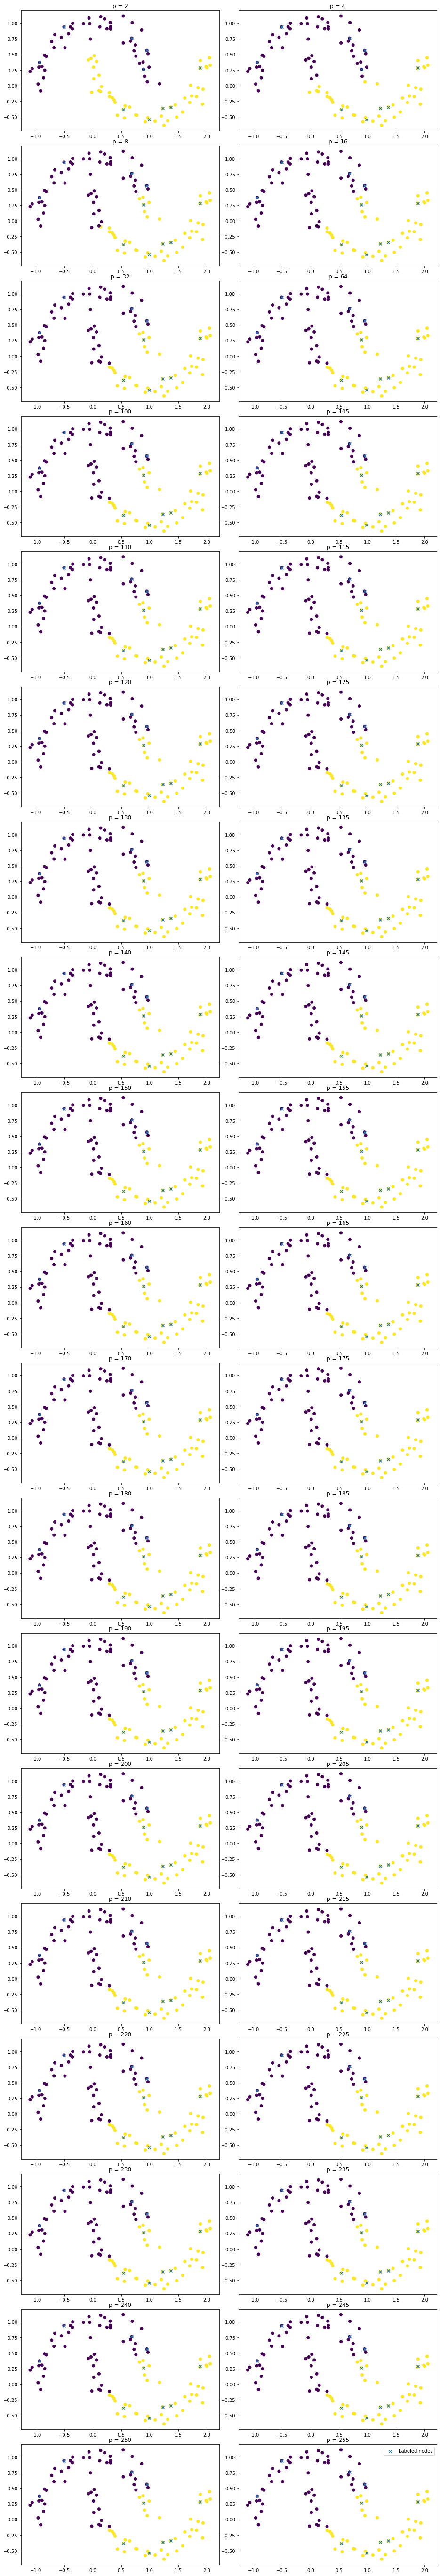

In [54]:
fig, ax = plt.subplots(nrows = len(p_vals), ncols = len(p_vals[0]), figsize = (13, 4*len(p_vals)))
fig.tight_layout()

solutions = {}

# Run and plot for varying p
for i in range(len(p_vals)):
    for j in range(len(p_vals[i])):
        start_time = time.time()

        p = p_vals[i][j]
        solutions[p] = ppoisson(p, W)

        uu = solutions[p].fit(train_ind, onehot_train_labels, start = u)
        uu_predictions = solutions[p].predict()

        discrepancies = np.count_nonzero(uu_predictions - pred_labels)
        accuracy = solutions[p].accuracy(labels)
        energy = np.around(penergy(uu.flatten(), W, train_ind, onehot_train_labels, p), 2)
        end_time = time.time()
        minutes = (end_time - start_time)/60
        
        info_str = f"########### Gradient Descent (w/ Jacobian) for p = {p}\n"\
                        f"Energy = {energy:.2f}\n"\
                        f"Discrepancies = {discrepancies}"\
                        f"\nAccuracy = {accuracy * 100:.2f}%\n"\
                        f"Runtime = {minutes:.2f} min"

        print(info_str)
                
        ax[i, j].scatter(X[:,0],X[:,1], c=uu_predictions)
        ax[i, j].scatter(X[train_ind,0],X[train_ind,1], marker='x', label = "Labeled nodes")
        ax[i, j].set_title(f"p = {p}")

        u = np.copy(uu)

plt.legend()
plt.show()



In [56]:
with open('twomoons_data', 'wb') as f:
    pickle.dump(solutions, f)
    f.close()